In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

In [3]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [4]:
train.info()
print ("--------")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
vidid        14999 non-null object
adview       14999 non-null int64
views        14999 non-null object
likes        14999 non-null object
dislikes     14999 non-null object
comment      14999 non-null object
published    14999 non-null object
duration     14999 non-null object
category     14999 non-null object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 8 columns):
vidid        8764 non-null object
views        8764 non-null object
likes        8764 non-null object
dislikes     8764 non-null object
comment      8764 non-null object
published    8764 non-null object
duration     8764 non-null object
category     8764 non-null object
dtypes: object(8)
memory usage: 547.8+ KB


# Data Cleanup

In [5]:
data = train.copy()

In [6]:
columns = ['adview', 'views', 'likes', 'dislikes', 'comment']
for x in columns:
    data[x] = data[x].apply(pd.to_numeric, errors = 'coerce')
    print (x, data[x].isnull().sum())

adview 0
views 2
likes 155
dislikes 155
comment 233


In [7]:
# NaN is at same position for Likes and Dislikes
data = data.dropna()

In [8]:
data.views = data.views.astype('int')
data.likes = data.likes.astype('int')
data.dislikes = data.dislikes.astype('int')
data.comment = data.comment.astype('int')

In [9]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [10]:
def time_transform(data1):
    duration = data1['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data1['duration'] = time
    data1.head()
    return data1

data = data.apply(time_transform, axis=1)

In [11]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,457,F
1,VID_14135,2,1707,56,2,6,2016-10-01,570,D
2,VID_2187,1,2023,25,0,2,2016-07-02,136,C
3,VID_23096,6,620860,777,161,153,2016-07-27,262,H
4,VID_10175,1,666,1,0,0,2016-06-29,31,D


In [12]:
def date_transformation(publisheds):
    return {'year':publisheds[:4], 'month':publisheds[5:7], 'date':publisheds[8:]}
#    for published in publisheds:
#        published = str(published)
#        published = published.split('-')
#        published = published[0]
#        print (published)
#    return publisheds

date = data.published.map(date_transformation)
#month.value_counts
#day.value_counts()

In [13]:
published = pd.DataFrame(list(date))
published.head()

,date,month,year
0,14,09,2016
1,01,10,2016
2,02,07,2016
3,27,07,2016
4,29,06,2016


In [14]:
print ('date', published.date.value_counts())
print ('month', published.month.value_counts())
print ('year', published.year.value_counts())

date 28    527
15    526
16    517
06    512
24    506
03    506
23    502
20    499
18    499
25    493
13    486
04    486
26    486
08    481
02    481
01    478
21    476
14    472
27    470
05    464
09    464
07    462
10    459
17    453
12    453
30    451
22    450
11    445
19    419
29    419
31    295
Name: date, dtype: int64
month 08    1554
07    1446
09    1401
06    1336
05    1203
12    1188
04    1186
10    1138
03    1126
11    1022
01    1022
02    1015
Name: month, dtype: int64
year 2016    4788
2015    3001
2014    2317
2013    1974
2012     992
2011     549
2017     543
2010     304
2009      94
2008      38
2006      20
2007      15
2005       2
Name: year, dtype: int64


In [15]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,457,F
1,VID_14135,2,1707,56,2,6,2016-10-01,570,D
2,VID_2187,1,2023,25,0,2,2016-07-02,136,C
3,VID_23096,6,620860,777,161,153,2016-07-27,262,H
4,VID_10175,1,666,1,0,0,2016-06-29,31,D


In [16]:
data.loc[data.published == '2016-12-27']

,vidid,adview,views,likes,dislikes,comment,published,duration,category
1201,VID_19227,1,1698868,815,292,45,2016-12-27,1228,G
1554,VID_4334,2,802908,2522,665,119,2016-12-27,529,D
1742,VID_11979,1333626,1344097,60,7,4,2016-12-27,58,D
2012,VID_11980,1497349,1525185,414,114,19,2016-12-27,69,D
9030,VID_1525,91,410124,2606,134,319,2016-12-27,56,B
11931,VID_12014,575,54650,171,25,5,2016-12-27,81,D


In [17]:
data.loc[data.duplicated('vidid')]
#Vidid is a unique field

,vidid,adview,views,likes,dislikes,comment,published,duration,category


In [18]:
data.category.value_counts()

D    7383
G    2473
E    1597
B     970
F     879
C     556
H     421
A     358
Name: category, dtype: int64

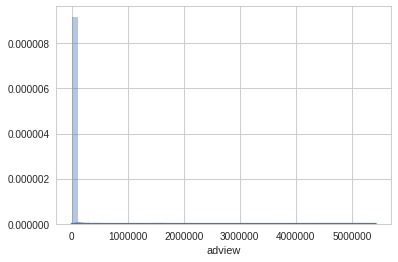

In [19]:
sns.distplot(data.adview)

In [20]:
data.adview.describe()

count    1.463700e+04
mean     2.066030e+03
std      5.282706e+04
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      5.429665e+06
Name: adview, dtype: float64

In [21]:
data.loc[data.adview > 1000000]

,vidid,adview,views,likes,dislikes,comment,published,duration,category
1200,VID_17354,1583846,17070057,98594,4234,7276,2016-06-30,189,E
1742,VID_11979,1333626,1344097,60,7,4,2016-12-27,58,D
2012,VID_11980,1497349,1525185,414,114,19,2016-12-27,69,D
9317,VID_22355,5429665,7072849,28360,4333,1872,2017-04-08,259,G


In [22]:
data.loc[data.views > 100000000]

,vidid,adview,views,likes,dislikes,comment,published,duration,category
3000,VID_22372,58,138047869,283824,15626,32271,2016-10-18,273,G


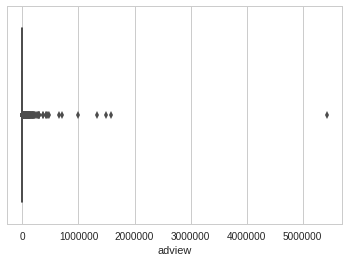

In [23]:
sns.boxplot(data['adview'])

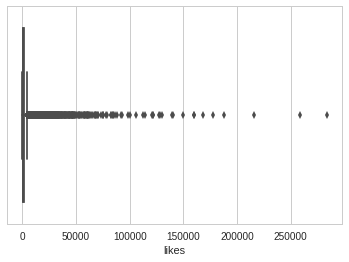

In [24]:
sns.boxplot(data.likes)

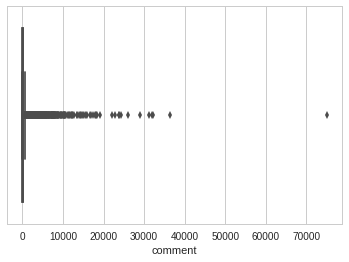

In [25]:
sns.boxplot(data.comment)

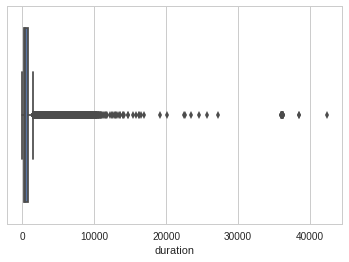

In [26]:
sns.boxplot(data.duration)

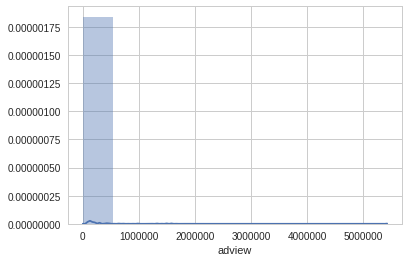

In [27]:
sns.distplot(data.adview, bins = 10)

In [28]:
data.skew()

adview      79.717422
views       21.184045
likes       11.652754
dislikes    19.473458
comment     16.076163
duration     6.976915
dtype: float64

In [29]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,457,F
1,VID_14135,2,1707,56,2,6,2016-10-01,570,D
2,VID_2187,1,2023,25,0,2,2016-07-02,136,C
3,VID_23096,6,620860,777,161,153,2016-07-27,262,H
4,VID_10175,1,666,1,0,0,2016-06-29,31,D


In [30]:
data.describe()

,adview,views,likes,dislikes,comment,duration
count,1.463700e+04,1.463700e+04,14637.000000,14637.000000,14637.000000,14637.000000
mean,2.066030e+03,7.112280e+05,2785.841293,254.429391,409.135547,1040.179067
std,5.282706e+04,2.731475e+06,8938.490736,1029.774864,1511.176934,2316.818747
min,1.000000e+00,4.900000e+01,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+00,3.151700e+04,88.000000,7.000000,7.000000,187.000000
50%,2.000000e+00,1.586680e+05,450.000000,38.000000,46.000000,325.000000
75%,6.000000e+00,5.836130e+05,1863.000000,167.000000,224.000000,723.000000
max,5.429665e+06,1.380479e+08,283824.000000,49449.000000,75045.000000,42317.000000


In [31]:
columns2 = ['adview', 'views', 'likes', 'duration','dislikes','comment']
data1 = pd.DataFrame(data,columns =columns2)
data1.head()

,adview,views,likes,duration,dislikes,comment
0,40,1031602,8523,457,363,1095
1,2,1707,56,570,2,6
2,1,2023,25,136,0,2
3,6,620860,777,262,161,153
4,1,666,1,31,0,0


In [32]:
data_scaled = preprocessing.scale(data1)

In [33]:
data_scaled = pd.DataFrame(data_scaled, columns = columns2)

In [34]:
data_scaled.describe()

,adview,views,likes,duration,dislikes,comment
count,1.463700e+04,1.463700e+04,1.463700e+04,1.463700e+04,1.463700e+04,1.463700e+04
mean,-4.601562e-16,-3.758390e-18,-4.452421e-17,-3.437922e-17,-1.020473e-16,7.433344e-18
std,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-3.909172e-02,-2.603734e-01,-3.116786e-01,-4.489840e-01,-2.470813e-01,-2.707489e-01
25%,-3.909172e-02,-2.488524e-01,-3.018332e-01,-3.682671e-01,-2.402834e-01,-2.661166e-01
50%,-3.907279e-02,-2.023005e-01,-2.613328e-01,-3.087007e-01,-2.101787e-01,-2.403080e-01
75%,-3.899706e-02,-4.672178e-02,-1.032471e-01,-1.369075e-01,-8.490436e-02,-1.225150e-01
max,1.027463e+02,5.028101e+01,3.144242e+01,1.781677e+01,4.777379e+01,4.939092e+01


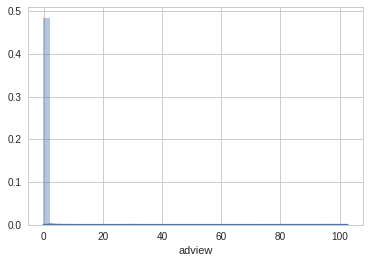

In [35]:
sns.distplot(data_scaled.adview)

In [36]:
skew(data_scaled.adview)

79.70925187548326

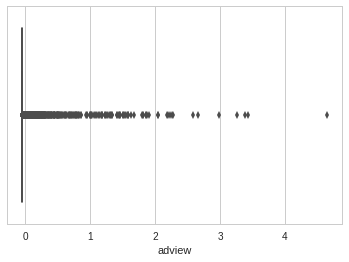

In [37]:
data_scaled['adview'] = np.log1p(data_scaled["adview"])
sns.boxplot(data_scaled.adview)

In [38]:
data2 = data.copy()

79.70925187548318

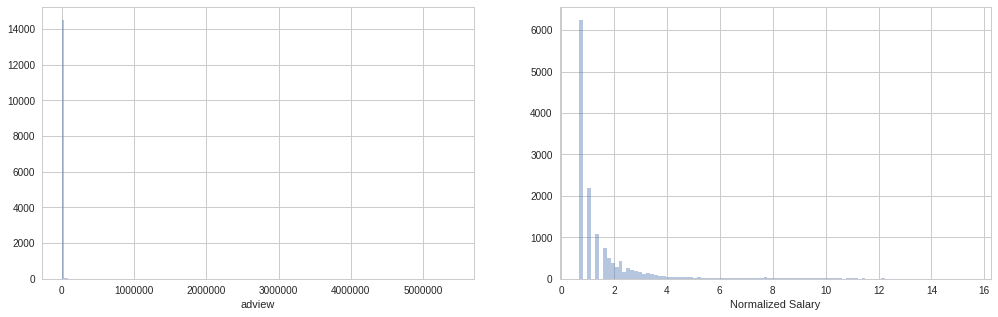

In [39]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(data2['adview'], kde = False, ax = ax1, bins = 200)
sns.distplot(np.log1p(data2["adview"]), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)
#data2['adview'] = np.log1p(data2["adview"])
skew(data2.adview)

In [40]:
data2['adview'] = np.log1p(data2["adview"])
skew(data2.adview)

2.9759959001879466

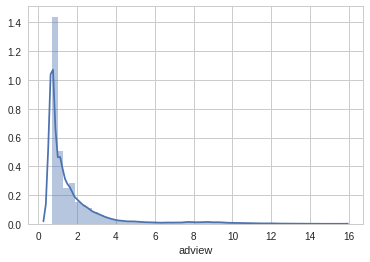

In [41]:
sns.distplot(data2.adview)

In [42]:

data2_scaled = preprocessing.scale(data2.adview)
data2_scaled = pd.DataFrame(data2_scaled)

In [43]:
data2_scaled.head()

,0
0,1.016029
1,-0.355132
2,-0.567739
3,0.089151
4,-0.567739


# ------------------------------------------------------------------------------------

In [44]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,457,F
1,VID_14135,2,1707,56,2,6,2016-10-01,570,D
2,VID_2187,1,2023,25,0,2,2016-07-02,136,C
3,VID_23096,6,620860,777,161,153,2016-07-27,262,H
4,VID_10175,1,666,1,0,0,2016-06-29,31,D


In [45]:
y_train = data['adview']
data.drop(['adview'], axis = 1, inplace=True)
x_train = data

In [46]:
x_train.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_18655,1031602,8523,363,1095,2016-09-14,457,F
1,VID_14135,1707,56,2,6,2016-10-01,570,D
2,VID_2187,2023,25,0,2,2016-07-02,136,C
3,VID_23096,620860,777,161,153,2016-07-27,262,H
4,VID_10175,666,1,0,0,2016-06-29,31,D


In [47]:
lbl = preprocessing.LabelEncoder()

In [48]:
lbl.fit(list(x_train['category'].values))
x_train['category'] = lbl.transform(list(x_train['category'].values))

In [49]:
x_train.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_18655,1031602,8523,363,1095,2016-09-14,457,5
1,VID_14135,1707,56,2,6,2016-10-01,570,3
2,VID_2187,2023,25,0,2,2016-07-02,136,2
3,VID_23096,620860,777,161,153,2016-07-27,262,7
4,VID_10175,666,1,0,0,2016-06-29,31,3


In [50]:
columns = ['views', 'likes', 'dislikes', 'comment', 'duration', 'category']

In [51]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(x_train[columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [52]:
x_train[columns] = std_scaler.transform(x_train[columns])

In [53]:
x_train.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_18655,0.117294,0.641871,0.105435,0.453877,2016-09-14,-0.251724,0.883593
1,VID_14135,-0.259766,-0.305413,-0.245139,-0.266778,2016-10-01,-0.202949,-0.385234
2,VID_2187,-0.259651,-0.308882,-0.247081,-0.269425,2016-07-02,-0.390281,-1.019648
3,VID_23096,-0.033085,-0.224748,-0.090731,-0.169500,2016-07-27,-0.335894,2.152421
4,VID_10175,-0.260147,-0.311567,-0.247081,-0.270749,2016-06-29,-0.435603,-0.385234


### PCA

In [54]:
cov_mat = np.cov(x_train[columns].T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [55]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [56]:
pca = PCA(n_components=6)
Y_pca = pca.fit_transform(x_train[columns])
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
print (Y_pca.shape)

[ 2.86127633  1.05764446  0.95093893  0.61592239  0.33626922  0.17794868]
[ 0.47687939  0.17627408  0.15848982  0.10265373  0.05604487  0.02965811]
[ 0.47687939  0.65315346  0.81164329  0.91429702  0.97034189  1.        ]
(14637, 6)


In [57]:
x_train.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_18655,0.117294,0.641871,0.105435,0.453877,2016-09-14,-0.251724,0.883593
1,VID_14135,-0.259766,-0.305413,-0.245139,-0.266778,2016-10-01,-0.202949,-0.385234
2,VID_2187,-0.259651,-0.308882,-0.247081,-0.269425,2016-07-02,-0.390281,-1.019648
3,VID_23096,-0.033085,-0.224748,-0.090731,-0.169500,2016-07-27,-0.335894,2.152421
4,VID_10175,-0.260147,-0.311567,-0.247081,-0.270749,2016-06-29,-0.435603,-0.385234


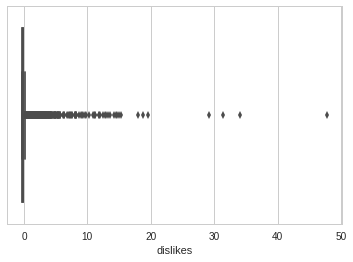

In [58]:
sns.boxplot(x_train.dislikes)

In [59]:
x_train.loc[x_train.views > 30]

,vidid,views,likes,dislikes,comment,published,duration,category
3000,VID_22372,50.281014,31.442418,14.927628,21.084859,2016-10-18,-0.331146,1.518007
7668,VID_21755,31.933688,13.353399,8.080266,4.554794,2016-03-19,-0.324671,1.518007


In [60]:
x_train.published = pd.to_datetime(x_train.published)

In [71]:
x_train.published.dt.dayofweek.head()

0    2
1    5
2    5
3    2
4    2
Name: published, dtype: int64

In [75]:
x_train.published.dt.

0        3
1        4
2        3
3        3
4        2
5        2
6        3
7        3
8        4
9        4
10       3
11       4
12       3
13       1
14       2
15       3
16       4
17       4
18       2
19       3
20       2
21       3
22       3
23       3
24       2
25       4
26       3
27       3
28       1
29       2
        ..
14966    2
14967    3
14968    1
14969    4
14970    1
14971    3
14972    1
14973    1
14974    3
14975    1
14976    3
14978    2
14979    2
14980    1
14981    1
14982    4
14983    3
14984    1
14985    1
14986    3
14987    2
14988    3
14989    2
14992    3
14993    1
14994    2
14995    4
14996    3
14997    4
14998    1
Name: published, Length: 14637, dtype: int64